### Tutorial 1: SMC - Spectral Multi-scale Coverage (Closed-form ergodic control)

References: 

[1] *Mathew, G. and Mezić, I.*, 2011. **Metrics for ergodicity and design of ergodic dynamics for multi-agent systems**. Physica D: Nonlinear Phenomena, 240(4-5), pp.432-442. [[**Link**](https://www.sciencedirect.com/science/article/pii/S016727891000285X)]

In [1]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

#### Introduction

Given a first-order system with the dynamics:

$$
\dot{x}(t) = f(x(t), u(t)) = u(t),
$$

the spectral milti-scale coverage (SMC) algorithm is a closed-form non-iterative feedback control algorithm for the system to asympotically reach ergodicity.

#### Algorithm description

As the preprocess of the algorithm, we first calculate all the Fourier basis coefficients $\{\phi_k\}$ of a target spatial distribution $p(x)$. Then, at time $t$ with the system state $x(t)$, we can compute the control signal $u(t)$ as:

$$
\begin{align}
    u(t) & = -u_d \cdot \frac{b(t)}{\vert b(t) \vert} \\
    b(t) & = \sum_{k} \lambda_k \cdot \left( \frac{1}{t} \int_{0}^{t} f_k(x(\tau)) d\tau -\phi_k \right) \cdot \nabla f_k(x(t)) \\
    \nabla f_k(x(t)) & = \begin{bmatrix} -\frac{k_1\pi}{L_1 h_k} \cdot \sin\left( \frac{k_1 \pi}{L_1} x_1 \right) \cos\left( \frac{k_2 \pi}{L_2} x_2 \right) \cdots \cos\left( \frac{k_d \pi}{L_d} x_d \right) \\ \vdots \\ -\frac{k_i\pi}{L_i h_k} \cdot \cos\left( \frac{k_1 \pi}{L_1} x_1 \right) \cdots \sin\left( \frac{k_i \pi}{L_i} x_i \right) \cdots \cos\left( \frac{k_d \pi}{L_d} x_d \right) \\ \vdots \\ -\frac{k_d\pi}{L_d h_k} \cdot \cos\left( \frac{k_1 \pi}{L_1} x_1 \right) \cdots \cos\left( \frac{k_{d-1} \pi}{L_{d-1}} x_{d-1} \right) \sin\left( \frac{k_d \pi}{L_d} x_d \right) \end{bmatrix} \in \mathbb{R}^d , 
\end{align}
$$

where $u_d\in\mathbb{R}_0^{+}$ is a scalar that represents the desired magnitude for the control at each time step.

We now show an example of the SMC algorithm in a 2D space with the target distribution defined in the last tutorial.

In [2]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.5

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])
w3 = 0.3

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3)

# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], 100),
    np.linspace(0, L_list[1], 100)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / 99
dy = 1.0 / 99 

In [3]:
# Configure the index vectors
num_k_per_dim = 20
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T

# Pre-processing lambda_k and h_k
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
hk_list = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk

# compute the coefficients for the target distribution
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    fk_vals /= hk

    phik = np.sum(fk_vals * pdf_vals) * dx * dy 
    phik_list[i] = phik

In [4]:
# Specify the dynamic system 
dt = 0.01
tsteps = 10000
ud = 0.2  # desired velocity 0.2 m/s

def dyn(xt, ut):
    xdot = ut 
    return ut

def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)
    return xt_new 

# start SMC iteration
xt = np.random.uniform(low=0.2, high=0.8, size=(2,))
x_traj = np.zeros((tsteps, 2))
ck_list_update = np.zeros(ks.shape[0])  # trajectory coefficients (update over time, not normalized)
metric_log = []  # record ergodic metric at each step
for t in range(tsteps):
    # step 1: evaluate all the fourier basis functions at the current state
    fk_xt_all = np.prod(np.cos(np.pi * ks / L_list * xt), axis=1) / hk_list
    
    # step 2: update the coefficients
    ck_list_update += fk_xt_all * dt

    # step 3: compute the derivative of all basis functions at the current state
    dfk_xt_all = np.array([
        -np.pi * ks[:,0] / L_list[0] * np.sin(np.pi * ks[:,0] / L_list[0] * xt[0]) * np.cos(np.pi * ks[:,1] / L_list[1] * xt[1]),
        -np.pi * ks[:,1] / L_list[1] * np.cos(np.pi * ks[:,0] / L_list[0] * xt[0]) * np.sin(np.pi * ks[:,1] / L_list[1] * xt[1]),
    ]) / hk_list
    
    # step 4: compute control signal
    bt = np.sum(lamk_list * (ck_list_update / (t*dt+dt) - phik_list) * dfk_xt_all, axis=1)
    ut = -ud * bt / np.linalg.norm(bt)
    # print('ut: ', np.linalg.norm(ut))
    
    # step 5: execute the control, move on to the next iteration
    xt_new = step(xt, ut)
    xt = xt_new.copy()
    x_traj[t] = xt.copy()
    
    erg_metric = np.sum(lamk_list * np.square(phik_list - ck_list_update / (t*dt+dt)))
    metric_log.append(erg_metric)

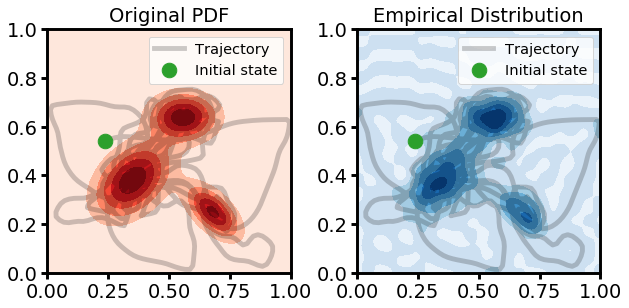

In [5]:
# reconstruct the emprical distribution
phi_recon = np.zeros(grids.shape[0])
for i, (k_vec, ck, hk) in enumerate(zip(ks, ck_list_update/(tsteps*dt), hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    fk_vals /= hk
    phi_recon += ck * fk_vals 

# visualize the trajectory
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Empirical Distribution')
ax.contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Blues')
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

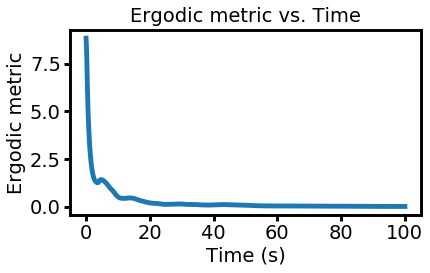

In [6]:
# Also visualize the ergodic metric over time
fig, ax = plt.subplots(1, 1, dpi=70, tight_layout=True)

ax.plot(np.arange(tsteps)*dt, metric_log)
ax.set_title('Ergodic metric vs. Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Ergodic metric')

plt.show()
plt.close()

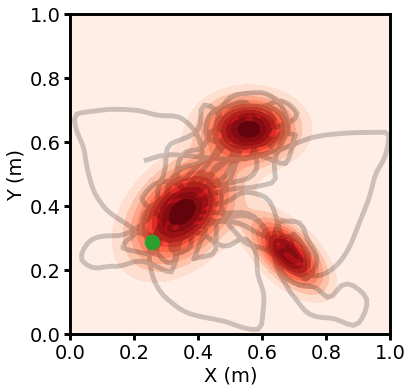

In [7]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', levels=10)

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 10)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::10], x_traj[:t,1][::10]
    )

    return robot_state, robot_traj,

ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/10)-1, blit=True, interval=30, repeat=False)
video = ani.to_html5_video()
HTML(video)